# Principal Component Analysis

Principal component analysis (PCA) is a statistical (or data mining) technique to extract from a set of points in a n-dimensional real-valued space a new representation on a reduced set of k dimensions. The main use is to reduce the dimensionaly of a data set with too many dimensions to be used directly, and in a sense the PCA technique can be seen as a kind of data compression technique. A similar dimension reduction technique (Singular Value Decomposition) is the basis of a class of recommender systems. But PCA is a more general tool, that can be used for any data set that we want to represent with a reduced set of dimensions, to understand easily how the values in the data points change in different dimensions.

An important property of the set of k dimensions obtained from the original ones is that they are obtained as projections of subsets of the original dimensions, but in such a way that they encode much of the variance observed in the variables with the original dimensions, where the higher the value we choose for k, the higher the total variance we can explain from the original set of dimensions with our reduced set of dimensions. Working with a reduced set of dimensions, but that they stil carry much of the variance present in the original set, can be helpful when we want later to work with machine learning algorithms that work better with less, but relevant, features when predicting the value of some target variables. This is because original variables that are highly correlated will be reduced to single ones with PCA.

In [ ]:
#
# Start-up code for the notebook
#

import pyspark 
import os 
import math 
import sys
import random

from pyspark.sql import SQLContext
from pyspark.sql.types import *
    
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


spark_home = os.environ.get('SPARK_HOME', None)
sc = pyspark.SparkContext('local[*]')
sqlContext = SQLContext(sc)

print (spark_home, sc)

In [7]:
from pyspark.ml.feature import *
from pyspark.mllib.linalg import Vectors

## Transforming our data with the eigenvectors of the covariance matrix

So, our goal is to transform our data to a new system of coordinates (a different set of dimensions), such that almost all the variance in the data can be explained with a smaller number of dimensions than in the original matrix. First, we need to compute the covariance matrix of our input matrix. The covariance matrix captures the covariance between any pair of dimensions of our matrix.


This is the standard definition of the covariance matrix for a matrix M with m data points (rows) and n dimensions per point (column):


$$ Cov( M ) = \frac{1}{m} (M-\mu)^T \times (M-\mu)  = \left( \begin{array}{4} E[(X_1-\mu_1)(X_1-\mu_1)] & E[(X_1-\mu_1)(X_2-\mu_2)] \ldots &  E[(X_1-\mu_1)(X_n-\mu_n)]  \\
E[(X_2-\mu_2)(X_1-\mu_1)] & E[(X_2-\mu_2)(X_2-\mu_2)] \ldots &  E[(X_2-\mu_2)(X_n-\mu_n)]  \\
\vdots &  \vdots  & \ddots &  \vdots \\
 E[(X_n-\mu_n)(X_1-\mu_1)] & E[(X_n-\mu_n)(X_2-\mu_2)] \ldots &  E[(X_n-\mu_n)(X_n-\mu_n)]   \end{array}  \right) $$

where $\mu$ represents the mean vector (the vector with the mean of each dimension) and $ E[(x_i-\mu)(x_j-\mu)] $ is the expected value for the covariance between the i and j dimensions, equal to:

$$ E[(x_i-\mu_i)(x_j-\mu_j)] = \frac{1}{m} \sum_{p \ \in \ m} (M_{p,i}-\mu_i)(M_{p,j}-\mu_j)$$

Observe that the regular variance of each dimension i is located at the diagonal element (i,i) of this matrix. If we sum up all the elements of the diagonal we get a measure of the total variance that all the dimensions in our data points have.

To implement efficiently in a map-reduce framework such operation, we can decompose it as a sum of outer products of individual data points, where the outer product for point $p$ ( $ M_p^T \cdot M_p $ ) with $n$ dimensions gives a $n \times n$ matrix that represents the contribution of that point in the covariance matrix:

$$ (M-\mu)^T \times (M-\mu) = (M_1-\mu)^T \cdot (M_1-\mu)  + (M_2-\mu)^T \cdot (M_2-\mu) + \ldots + (M_m-\mu)^T \cdot (M_m-\mu)  $$



The outer product for point p (with mean substracted) is:

$$ (M_p-\mu)^T \cdot (M_p-\mu) = \left(  \begin{array}{4} (M_{p,1}-\mu_1)(M_{p,1}-\mu_1) &  (M_{p,1}-\mu_1)(M_{p,2}-\mu_2) & \ldots & (M_{p,1}-\mu_1)(M_{p,n}-\mu_n) \\ 
(M_{p,2}-\mu_2)(M_{p,1}-\mu_1) &  (M_{p,2}-\mu_2)(M_{p,2}-\mu_2) & \ldots & (M_{p,2}-\mu_2)(M_{p,n}-\mu_n) \\ 
\vdots &  \vdots & \ddots & \vdots \\
(M_{p,n}-\mu_n)(M_{p,1}-\mu_1) &  (M_{p,n}-\mu_n)(M_{p,2}-\mu_2) & \ldots & (M_{p,n}-\mu_n)(M_{p,n}-\mu_n)
\end{array} \right)  $$

### Efficient  implementation with map-reduce

Decomposing the computation of $ (M-\mu)^T \times (M-\mu)  $ as a sum of outer products, instead of computing each entry of the result matrix as an inner product of a row by a column, allows a more efficient distributed computation, because:
1. Each outer product only involves the values of a single point, so each outer product can be computed locally independently of all the other outer products, so overall we have a single map transformation from the set of points to the set of outer products
2. Then, all the outer products can be summed up with a single reduce operation.

By contrast, think about what would happen if we instead used inner products of rows by columns to compute  $ (M-\mu)^T \times (M-\mu)  $.

Consider the following example matrix, with four points (rowss) in a 2-dimensional space. We represent such matrix as a dataframe with each point represented as a Dense Vector with 2 values. We label such set of vectors with column name "features" 

In [8]:
data1 = [(Vectors.dense([1.0, 2.0]),),
         (Vectors.dense([2.0, 1.0]),),
         (Vectors.dense([3.0, 4.0]),),
         (Vectors.dense([4.0, 3.0]),)]
df1 = sqlContext.createDataFrame(data1,["features"])

First, we need a function to compute the covariance matrix (M^T M), where M is the original matrix but normalized substracting the mean of each dimension. Observe that this function returns the covariance matrix as a regular matrix back to the driver (it is not stored in a dataframe or a plain RDD). We do it in this way because the function we are going to use in the next function to compute the eigenvectors and eigenvalues needs the matrix data in this format. We will see later that we can instead use an spark function to compute the PCA of a matrix, but without obtaining so much information as the one we are presenting now.

In [9]:
# This function and the next we show to compute the PCA come from this post:
#
#   http://stackoverflow.com/questions/33428589/pyspark-and-pca-how-can-i-extract-the-eigenvectors-of-this-pca-how-can-i-calcu

def estimateCovariance(df):
    """Compute the covariance matrix for a given dataframe.
       Performs the matrix multiplication M^T x M using
       outer products instead of inner products, because for 
       this particular multiplication the work to be done
       is more efficient, in terms of the number of independent
       operations between different partitions of the RDD.

    Args:
        df:  A Spark dataframe with a column named 'features',
             which    consists of DenseVectors, where
             each vector is a data point of our input matrix

    Returns:
        numpy.ndarray: A multi-dimensional array where the number
                       of rows and columns both equal the
                        length of the arrays in the input dataframe
                        (the symmetric  n x n  covariance matrix)
    """
    # Compute the mean vector, where each value is the mean value
    # of each dimension, so it will be a vector with n values
    m = df.select(df['features']).rdd.map(lambda x: x[0]).mean()
    print (" mean vector : ", m )
    
    # subtract the mean from each dimension
    rddZeroMean = df.select(df['features']).rdd.map(lambda x: x[0]).map(lambda x: x-m) 
    # print dfZeroMean.collect()
    
    # Perform matrix multiplication with outer products and sum of matrices
    # For our particular M^T x M multiplication, this way of performing
    # multiplication is more efficient than with inner products.
    outerproducts = rddZeroMean.map(lambda x: np.outer(x,x))        
    return outerproducts.sum()/df.count()

Let's compute the covariance matrix of our example matrix:

In [10]:
covm = estimateCovariance(df1)
print (type(covm))
print (covm)

 mean vector :  [2.5,2.5]
<class 'numpy.ndarray'>
[[ 1.25  0.75]
 [ 0.75  1.25]]


In [11]:
# Some debugging, computing the covariance with the inner products,
# by first substracting the mean from each dimension:

print (((-1.5*-1.5) + (-0.5*-0.5) + (0.5*0.5) + (1.5*1.5))/4.0, ((-1.5*-0.5) + (-0.5*-1.5) + (0.5*1.5) + (1.5*0.5))/4.0)
print (((-0.5*-1.5) + (-1.5*-0.5) + (1.5*0.5) + (0.5*1.5))/4.0, ((-0.5*-0.5) + (-1.5*-1.5) + (1.5*1.5) + (0.5*0.5))/4.0)

1.25 0.75
0.75 1.25


The next step is to compute the set of eigenvectors and eigenvalues of the covariance matrix, and to order them in **descending order** by the magnitude of their eigenvalues. The idea is that this order will tell us which dimensions are more important in terms of the "weight" they have in the total variance in the new coordinate system. The axis of this new set of coordinates will be given by the set of eigenvectors, with the first dimension (axis) carrying the most variance, the second one the second most high variance, and so on.

Here we have a function for computing the eigenvectors and eigenvalues of our data frame with data points, using the previously covariance matrix computation function and then computing its set of eigenvectors and eigenvalues and sort them by the eigenvalues in descending order:

In [42]:
def pca(df, k=2):
    """Computes the top `k` principal components, corresponding scores 
       (points transformed in the new coordinate
       system given by the top k eigenvectors), and all eigenvalues.
 
    Note:
        All eigenvalues are returned in sorted order (largest to smallest).
        Use  the`eigh` function from numpy.linalg to compute eigenvectors and eigenvalues.
 
    Args:
        df: A Spark dataframe with a 'features' column, which (column) 
            consists of DenseVectors.
        k (int): The number of principal components to return.
 
    Returns:
        tuple of (np.ndarray, DF of DenseVector, np.ndarray): A tuple of
           (eigenvectors, DF of  scores, eigenvalues).
           Eigenvectors is a multi-dimensional array where the number of
            rows equals the length of the array in the input `DF` and
            the number of columns equals `k`.
            The `DF` of scores has the same number of rows as `df` and
            consists of DenseVectors of length `k`.
            Eigenvalues is an array of length d (the number of dimensions
            of the input matrix).
    """
    cov = estimateCovariance(df)
    col = cov.shape[1]
    print (" covariance matrix: \n", cov)
    print ( " Total Variance : ", sum( cov[i][i] for i in range(col)) )
    eigVals, eigVecs = np.linalg.eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  # sort eigenvectors by eigenvalues
    print (" eigenVecs : ", eigVecs)
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]  # sort eigenvalues
    scoreRDD = df.select(df['features']).rdd.map(lambda x: x[0]).\
                  map(lambda x: np.dot(x, components.T) )
    scoreDF = sqlContext.createDataFrame(\
                scoreRDD.map(lambda x: (Vectors.dense(x),)), ['pca_features'])
    # Return the `k` principal components, `k` scores, and all eigenvalues
     
    return components.T, scoreDF, eigVals


A few words about the efficiency of the proposed approach to compute the k principal components. The 'pipeline' we are proposing first computes the covariance matrix in a efficiently distributed manner using outer products, then the resulting matrix is stored back to the driver memory. This is Ok as far as the number of dimensions of the input data matrix n is small enough for the resulting n x n covariance matrix to fit into main memory of one node. We can say that this will be true for *many* applications (we typically have many data points but not too many dimensions). But this will be not the case in any application domain.
Then, once we have the covariance matrix, we compute the full set of eigenvalues and eigenvectors, even if we only need the top k ones. This has the advantage that we can 'explore' if it may be better to select a bigger value for k than increases significantly the variance explained. But the disadvantage is that we may be computing more eigenvalues and eigenvectors than we really need.

That's the reason why we can think of other approaches, like the one we will explain later.

Let's try our current approach with our example matrix:

In [15]:
vectors,transformedDF,eigenvalues = pca(df1,k=2)
print (" ------ ")
print (" New coordinate system with k components (k column vectors of dimension n):")
for vec in vectors:
    print ("   ",vec)
transformedPoints = transformedDF.select(transformedDF['pca_features']).rdd.\
                   map( lambda x : x[0]).collect()
print ("\n Data set transformed with new coordinate system : ")
for vec in transformedPoints:
     print ("   ",vec)
print ("\nWhole set of eigenvalues ", eigenvalues )

 mean vector :  [2.5,2.5]
 covariance matrix: 
 [[ 1.25  0.75]
 [ 0.75  1.25]]
 eigenVecs :  [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
 ------ 
 New coordinate system with k components (k column vectors of dimension n):
    [ 0.70710678 -0.70710678]
    [ 0.70710678  0.70710678]

 Data set transformed with new coordinate system : 
    [2.12132034356,0.707106781187]
    [2.12132034356,-0.707106781187]
    [4.94974746831,0.707106781187]
    [4.94974746831,-0.707106781187]

Whole set of eigenvalues  [ 2.   0.5]


Observe that the total variance of the  original set of dimensions is 1.25 + 1.25 = 2.5 the same that the total variance with the new set of dimensions (2+0.5) because in this case k is equal to the same number of original dimensions (2). However, there is an interesting different between the original system and the transformed one. In the original one the variance is equally distributed between both dimensions, so in this sense both dimensions were equally important. However, in the new transformed set the **first dimension** carries almost all the variance (2/2.5 * 100 = 80%) of the total variance.


So, the transformation transfers more variance to the first dimensions, in this case most of the variance is found in the new 1st dimension, and only a small one is found in the second one. This means that we could even pick only the first transformed dimension to represent our data, and we will still capturing most of the original variance.


We have said that the transformed points can be actually thinked of as rotations of the original points. Let's plot the original points and the transformed ones to observe such rotation and compare the transformed points with the original ones

 Original points [x] [y]:  [1.0, 2.0, 3.0, 4.0] [2.0, 1.0, 4.0, 3.0] 

 Transformed points [x] [y]:  [2.1213203435596424, 2.1213203435596424, 4.9497474683058318, 4.9497474683058318] [0.70710678118654746, -0.70710678118654746, 0.70710678118654746, -0.70710678118654746] 



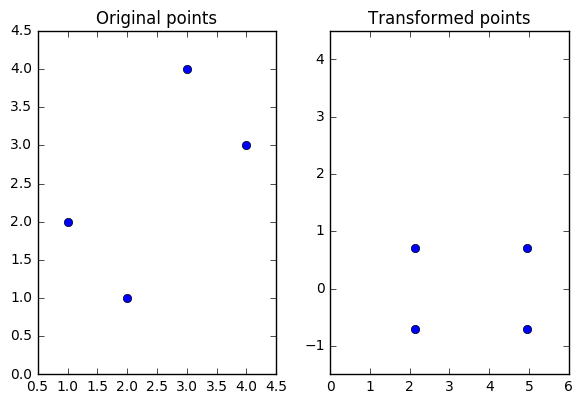

In [16]:
data1x = [ x[0][0] for x in data1 ]
data1y = [ x[0][1] for x in data1 ]

data1tx = [ x[0] for x in transformedPoints ]
data1ty = [ x[1] for x in transformedPoints ]

print (" Original points [x] [y]: ", data1x, data1y, "\n")
print (" Transformed points [x] [y]: ", data1tx, data1ty,"\n")

fig, ((pl1,pl2)) = plt.subplots(nrows=1,ncols=2)
plt.tight_layout()

# pl1 = fig.add_subplot(121)
pl1.plot( data1x, data1y , 'o')
pl1.axis([0.5, 4.5, 0, 4.5])
pl1.set_title('Original points')

# pl2 = fig.add_subplot(122)
pl2.plot( data1tx, data1ty , 'o')
pl2.axis([0.0, 6.0,-1.5, 4.5])
pl2.set_title('Transformed points')

plt.show()

We can observe that in the original points both the x-axis and the y-axis show the same variance in the values for the four points. By contrast, in the transformed (rotated) points we have more variance in the x-axis than in the y-axis

Let's see now an example with three dimensions, to check if we can represent it with enough detail (variance) selecting only the two most relevant dimensions of the PCA transformation

In [17]:
data2 = [(Vectors.dense([1.0, 2.0, 1.0]),),
         (Vectors.dense([2.0, 1.0, 1.0]),),
         (Vectors.dense([3.0, 4.0, 1.0]),),
         (Vectors.dense([4.0, 3.0, 1.0]),),
         (Vectors.dense([1.0, 2.0, 3.0]),),
         (Vectors.dense([2.0, 1.0, 3.0]),),
         (Vectors.dense([3.0, 4.0, 3.0]),),
         (Vectors.dense([4.0, 3.0, 3.0]),)]
df2 = sqlContext.createDataFrame(data2,["features"])

Let's see the points in a 3D scatter plot:

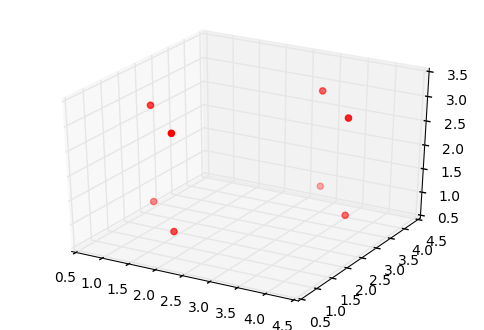

In [18]:
from mpl_toolkits.mplot3d import Axes3D

data2x = [ x[0][0] for x in data2 ]
data2y = [ x[0][1] for x in data2 ]
data2z = [ x[0][2] for x in data2 ]

threedee = plt.figure().gca(projection='3d')
threedee.scatter(data2x ,data2y ,data2z, color='red', marker='o')

plt.show()

So, observe that what we have is the original set of points of the original data set but at two different *heights* (z=1 and z=3) Do you think that the principal components will be similar to the ones of the previous data set ? Let's check it.

In [20]:
#
# We will try with k=3, to transform the 3 input dimensions to a new
# 3-dimensional space
#
vectors2,transformedDF2,eigenvalues2 = pca(df2,k=3)
print (" ------ ")
print (" New coordinate system with k components :\n")
for vec in vectors2:
    print ("   ",vec)
transformedPoints2 = transformedDF2.select(transformedDF2['pca_features']).rdd.\
                     map( lambda x : x[0]).collect()
print ("\n Data set transformed with new coordinate system :\n ")
for vec in transformedPoints2:
     print ("   ",vec)
print ("\nWhole set of eigenvalues ", eigenvalues2)

 mean vector :  [2.5,2.5,2.0]
 covariance matrix: 
 [[ 1.25  0.75  0.  ]
 [ 0.75  1.25  0.  ]
 [ 0.    0.    1.  ]]
 eigenVecs :  [[ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]
 [-0.70710678  0.70710678  0.        ]]
 ------ 
 New coordinate system with k components :

    [ 0.70710678  0.         -0.70710678]
    [ 0.70710678  0.          0.70710678]
    [ 0.  1.  0.]

 Data set transformed with new coordinate system :
 
    [2.12132034356,1.0,0.707106781187]
    [2.12132034356,1.0,-0.707106781187]
    [4.94974746831,1.0,0.707106781187]
    [4.94974746831,1.0,-0.707106781187]
    [2.12132034356,3.0,0.707106781187]
    [2.12132034356,3.0,-0.707106781187]
    [4.94974746831,3.0,0.707106781187]
    [4.94974746831,3.0,-0.707106781187]

Whole set of eigenvalues  [ 2.   1.   0.5]


Observe that as before, the total variance in the transformed space (2+1+0.5) is equal to the total variance of the original space (1.25+1.25+1) and that the new space condenses more variance in the first two dimensions, letting only a small variance (0.5) in the third dimension. So, in a sense, we can say that the new third dimension is carrying very little information in our data set. Observe also that the transformation has actually moved the previous value of z to y (and such that the previous variance of the z dimension is now found on the new y dimension). Let's plot the transformed set of points. The red points will be the original ones and the blue ones the transformed ones.

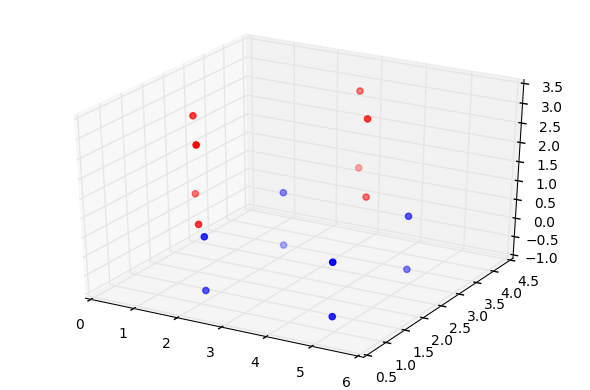

In [21]:
data2tx = [ x[0] for x in transformedPoints2 ]
data2ty = [ x[1] for x in transformedPoints2 ]
data2tz = [ x[2] for x in transformedPoints2 ]

fig = plt.figure().gca(projection='3d')

fig.scatter(data2x ,data2y ,data2z, color='red', marker='o')
fig.scatter(data2tx ,data2ty ,data2tz, color='blue', marker='o')

plt.tight_layout()
plt.show()

Observe that as before, the transformation can be seen as a *rotation* of the original data points applied to each dimension. Our original 'cube' has been rotated such that now much of the variance lies on the first (x) dimension, the next biggest variance lies on the second dimension (y) and the remaining one lies in the third (z) dimension. That means that setting k to 2 would actually give us a 2D version of our original space that would retain much of the information present in the original 3D space. 

Let's finally explore one more example with three dimensions. This time, the two first dimensions are highly correlated, and the thid one shows no variance at all (and so no covariance with the other two dimensions). So, we can see that in the final transformed set of dimensions all the variance is found in the first principal component, with the other two possible dimensions carrying no variance at all.

In [22]:
data3 = [(Vectors.dense([1.0, 3.0, 7.0]),),
         (Vectors.dense([2.0, 6.0, 7.0]),),
         (Vectors.dense([3.0, 9.0, 7.0]),),
         (Vectors.dense([1.0, 3.0, 7.0]),),
         (Vectors.dense([2.0, 6.0, 7.0]),),
         (Vectors.dense([3.0, 9.0, 7.0]),),
         (Vectors.dense([1.0, 3.0, 7.0]),),
         (Vectors.dense([2.0, 6.0, 7.0]),)]
df3 = sqlContext.createDataFrame(data3,["features"])

In [23]:
vectors3,transformedDF3,eigenvalues3 = pca(df3,k=2)
print (" ------ ")
print (" New coordinate system with k components :\n")
for vec in vectors3:
    print (" ->  ",vec)
transformedPoints3 = transformedDF3.select(transformedDF3['pca_features']).\
                      rdd.map( lambda x : x[0]).collect()
print ("\n Data set transformed with new coordinate system :\n ")
for vec in transformedPoints3:
     print ("   ",vec)
print ("\nWhole set of eigenvalues ", eigenvalues3)

 mean vector :  [1.875,5.625,7.0]
 covariance matrix: 
 [[ 0.609375  1.828125  0.      ]
 [ 1.828125  5.484375  0.      ]
 [ 0.        0.        0.      ]]
 eigenVecs :  [[ 0.31622777  0.9486833   0.        ]
 [ 0.          0.          1.        ]
 [-0.9486833   0.31622777  0.        ]]
 ------ 
 New coordinate system with k components :

 ->   [ 0.31622777  0.        ]
 ->   [ 0.9486833  0.       ]
 ->   [ 0.  1.]

 Data set transformed with new coordinate system :
 
    [3.16227766017,7.0]
    [6.32455532034,7.0]
    [9.48683298051,7.0]
    [3.16227766017,7.0]
    [6.32455532034,7.0]
    [9.48683298051,7.0]
    [3.16227766017,7.0]
    [6.32455532034,7.0]

Whole set of eigenvalues  [ 6.09375  0.       0.     ]


So, observe that in this last example **only the first new dimension** carries the whole variance of the original set of points, with the other two dimensions being fixed with constant values (7 and 0). This is also observed in the eigenvalues of the covariance matrix, where only the first eigenvalue is greater than 0. To conclude, in this example is enough to set k=1 to have a reduced set of dimensions without losing any of the variance of the original set of points.

## Finding correlated columns in the GDELT data set

Next, we are going to check if we cand find some columns that have a similar "behaviour" in the GDELT10 data set we worked with in a previous notebook. In particular, we are going to work with the columns: 'NumMentions', 'NumSources', 'NumArticles'.

Following their description, we suspect that there is some correlation in the values of these columns. So, considering only these three columns, we have as input a data set of columns with three dimensions. Then, we transform such vectors to a DF of dense vectors, and then we apply PCA with k=2 to check if we can reduce the dimensionality of such columns to only 2.

In [46]:
def parseGDELT10line( line ):
    return line.split("\t")

hlinefile = open( "CSV.header.historical.txt")
GDELT10headerline = hlinefile.readline().rstrip().split("\t")
hlinefile.close()
print (GDELT10headerline, "\n")
# Get the column index for the 'EventCode' column
selcolumns = [   GDELT10headerline.index( col ) for col in ['NumMentions', 'NumSources', 'NumArticles'] ]
print ("Selected columns: ", selcolumns)

['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate', 'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode', 'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code', 'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code', 'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode', 'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code', 'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent', 'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass', 'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Type', 'Actor1Geo_FullName', 'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type', 'Actor2Geo_FullName', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code', 'Actor2Geo_Lat', 'Actor2Geo_Long', 'Actor2Geo_FeatureID', 'ActionGeo_Type', 'ActionGeo_FullName', 'ActionGeo_CountryCode', 'ActionGeo_ADM1Code', 'ActionGeo_Lat', 

In [47]:
rddGDELT1979 =  sc.textFile( "GDELT10/1979.csv" ).map(parseGDELT10line)
rddGDELT1979filtered = rddGDELT1979.map( lambda x : (Vectors.dense([x[i] for i in selcolumns]),) )

print (rddGDELT1979filtered.take(3))

gdelt1979df = rddGDELT1979filtered.toDF(["features"])

[(DenseVector([9.0, 1.0, 9.0]),), (DenseVector([10.0, 1.0, 10.0]),), (DenseVector([10.0, 1.0, 10.0]),)]


In [48]:
vectors4,transformedDF4,eigenvalues4 = pca(gdelt1979df,k=2)
print (" ------ ")
print (" New coordinate system with k components :\n")
for vec in vectors4:
    print (" ->  ",vec)
transformedPoints4 = transformedDF4.select(transformedDF4['pca_features']).\
                      rdd.map( lambda x : x[0]).take(10)
print ("\n Data set transformed with new coordinate system :\n ")
for vec in transformedPoints4:
     print ("   ",vec)
print ("\nWhole set of eigenvalues ", eigenvalues4)


 mean vector :  [4.42018048874,1.00198170979,4.3697049016]
 covariance matrix: 
 [[  1.16435328e+01   1.40858397e-02   9.97735519e+00]
 [  1.40858397e-02   2.04275671e-03   1.36939210e-02]
 [  9.97735519e+00   1.36939210e-02   9.74258018e+00]]
 Total Covariance :  21.3881557136
 eigenVecs :  [[ -7.39875991e-01  -9.47894068e-04  -6.72742610e-01]
 [ -6.72743277e-01   9.80780329e-04   7.39875342e-01]
 [  4.15107288e-05  -9.99999070e-01   1.36334518e-03]]
 ------ 
 New coordinate system with k components :

 ->   [-0.73987599 -0.67274328]
 ->   [-0.00094789  0.00098078]
 ->   [-0.67274261  0.73987534]

 Data set transformed with new coordinate system :
 
    [-12.714515304,0.605169368682]
    [-14.1271339051,0.672301434055]
    [-14.1271339051,0.672301434055]
    [-2.82618509627,0.135244911074]
    [-7.06404089958,0.336641107192]
    [-8.47665950068,0.403773172564]
    [-12.714515304,0.605169368682]
    [-2.82618509627,0.135244911074]
    [-2.82618509627,0.135244911074]
    [-11.3018967029

In [53]:
totalVariance = sum( eigenvalues4 )
sumOfK =  sum( [ eigenvalues4[i] for i in range(2)])
print ( "Covariance  explained with k=", 2 , " main components ", sumOfK,\
         " fraction explained : ", sumOfK / totalVariance )

Covariance  explained with k= 2  main components  21.3861322111  fraction explained :  0.999905391448


So, observe that with only two dimensions we capture almost all the variance of the original three dimensions. Actually, taking only the first principal component (k=1) we explain about 96% of the variance.

#### EXERCISE: Comparing the variance between the original dimensions and the new set of k dimensions

To quantify how much variance we are *explaining* with our reduced set of k dimensions obtained from PCA, with respect to the total variance we have with the original set of n dimensions, implement a function that computes the variance of each dimension in a dataframe with points as DenseVectors, and returns the sum of the variances. Then, using this function with the original input dataframe and then with the one obtained with the PCA function, you can compare the variances to check if the value for k selected is *enough* to capture much of the variance with the reduced set of dimensions.

Observe that in this exercise we are simply asking to compute the same variance information that we already show in the output of our PCA algorithm, but now we want to compute it for any set of input vectors (independently of how the vectors were computed).

In [ ]:
def computeVarianceOfDimensions( df, featurecolname ):
    """
      This function should compute the variance of each dimension of the DenseVectors
      found in the column with name 'featurecolname' in the dataframe df, return them
       as a single DenseVector and return also the sum of all such  variances
    """
    #
    # INSER YOUR CODE HERE
    #
    return VectorOfVariances,sumOfVariances

Test your function computing the variance of df2 and of transformedDF2, to compare how much of the total variance are you explaining with the selected top k components: 

In [22]:
#
# Compute and compare the variance of df2 and transformedDF2 with the previous function
#    computeVarianceOfDimensions( df, featurecolname )
#
#  INSERT YOUR CODE HERE:

## PCA with the spark machine learning library

There is an implementation of the PCA algorithm in spark:

https://spark.apache.org/docs/2.1.0/api/python/pyspark.ml.html#pyspark.ml.feature.PCA

However, the difference between that spark function and the solution we have provided here is that in our solution, as we provide the FULL set of eigenvalues of the covariance matrix, we can compute the variance we can explain with any subset of the eigenvalues, so we can decide if the selected value for k is *good enough* or it is worth to increase the value of k. 

In [44]:
import pyspark.ml.linalg  as mlalg

data2 = [(mlalg.DenseVector([1.0, 2.0]),),
         (mlalg.DenseVector([2.0, 1.0]),),
         (mlalg.DenseVector([3.0, 4.0]),),
         (mlalg.DenseVector([4.0, 3.0]),)]
df2 = sqlContext.createDataFrame(data2,["features"])


sparkpca = pyspark.ml.feature.PCA(k=2, inputCol="features", outputCol="pca_features")
print (sparkpca.explainParams())

inputCol: input column name. (current: features)
k: the number of principal components (current: 2)
outputCol: output column name. (default: PCA_45ebafe9f0b8ef49b2fc__output, current: pca_features)


In [45]:
# Execute the PCA algorithm:


modeldf2 = sparkpca.fit(df2)

# Get the transformed points:
transformeddf2 = modeldf2.transform(df2)
transdata2 = transformeddf2.select(transformeddf2['pca_features']).\
             rdd.map( lambda x : x[0]).collect()
print (transdata2)
for i,point in enumerate(transdata2):
    print (point, " and same point with our PCA model: ", transformedPoints[i])
    
print ("Explained Proportion of Variance: ", modeldf2.explainedVariance)

[DenseVector([-2.1213, 0.7071]), DenseVector([-2.1213, -0.7071]), DenseVector([-4.9497, 0.7071]), DenseVector([-4.9497, -0.7071])]
[-2.12132034356,0.707106781187]  and same point with our PCA model:  [2.12132034356,0.707106781187]
[-2.12132034356,-0.707106781187]  and same point with our PCA model:  [2.12132034356,-0.707106781187]
[-4.94974746831,0.707106781187]  and same point with our PCA model:  [4.94974746831,0.707106781187]
[-4.94974746831,-0.707106781187]  and same point with our PCA model:  [4.94974746831,-0.707106781187]
Explained Proportion of Variance:  [0.8,0.2]


Well, the set of transformed points is not exactly the same one, but each dimension carries the same variance as the ones we obtained with our solution. The difference can come from the differences between the actual algorithms used to compute eigenvalues and eigenvectors. That is, the set of eigenvalues will be the same, but we can obtain a set of eigenvectors that is equivalent to the one obtained with another algorithm, but where the directions and magnitudes of some vectors are different (although the coordinate system they define should be equivalent).